In [77]:
import tensorflow as tf
import re
import string
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import pickle

In [3]:
fake_df = pd.read_csv('Fake/Fake.csv')
real_df = pd.read_csv('True/True.csv')

In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Match the subject names in both fake and real news

In [5]:
fake_df['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real_df['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [7]:
fake_df['subject'] = fake_df['subject'].replace({'News':'Worldnews','politics':'PoliticsNews','left-news':'Left-news'})

In [8]:
fake_df['subject'].unique()

array(['Worldnews', 'PoliticsNews', 'Government News', 'Left-news',
       'US_News', 'Middle-east'], dtype=object)

In [9]:
real_df['subject'] = real_df['subject'].replace({'worldnews':'Worldnews','politicsNews':'PoliticsNews'})

In [10]:
real_df['subject'].unique()

array(['PoliticsNews', 'Worldnews'], dtype=object)

Check For Null Values

In [11]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [12]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [13]:
#No null values found

Add target column to data

In [14]:
real_df['target'] = 0
fake_df['target'] = 1

Distribution of Fake and Real News

Text(0, 0.5, '# of News Articles')

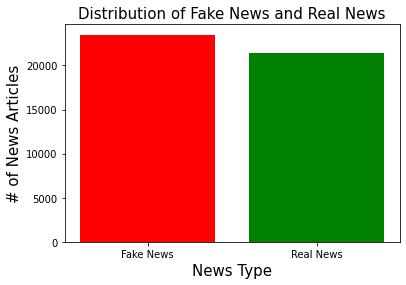

In [15]:
plt.figure()
plt.bar('Fake News', len(fake_df), color='red')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)

Ccombine real and fake news data

In [16]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)

<AxesSubplot:xlabel='subject', ylabel='count'>

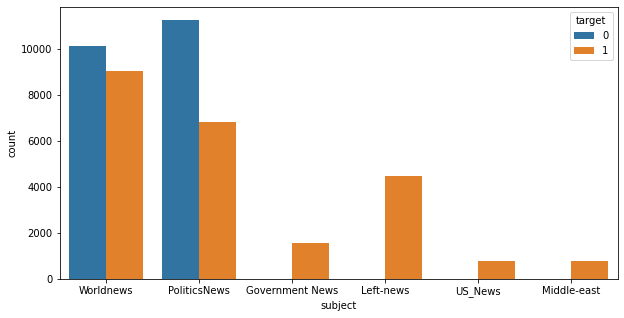

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(ax = ax,x="subject",  hue='target', data=news_df)

In [18]:
news_df['content'] = news_df['title'] + ' ' + news_df['text']

In [19]:
del news_df['title']
del news_df['text']
del news_df['subject']
del news_df['date']

In [20]:
news_df.head()

,target,content
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...


Clean data

In [21]:
stop_word_dict = {sw:'' for sw in STOPWORDS}
news_df['content'] = news_df['content'].replace(stop_word_dict)

In [22]:
X = news_df['content']
y = news_df['target']

In [23]:
X = tf.strings.lower(X)

In [24]:
X = tf.strings.regex_replace(X,'[%s]' % re.escape(string.punctuation),'')

In [25]:
X = X.numpy()
y = np.array(y)

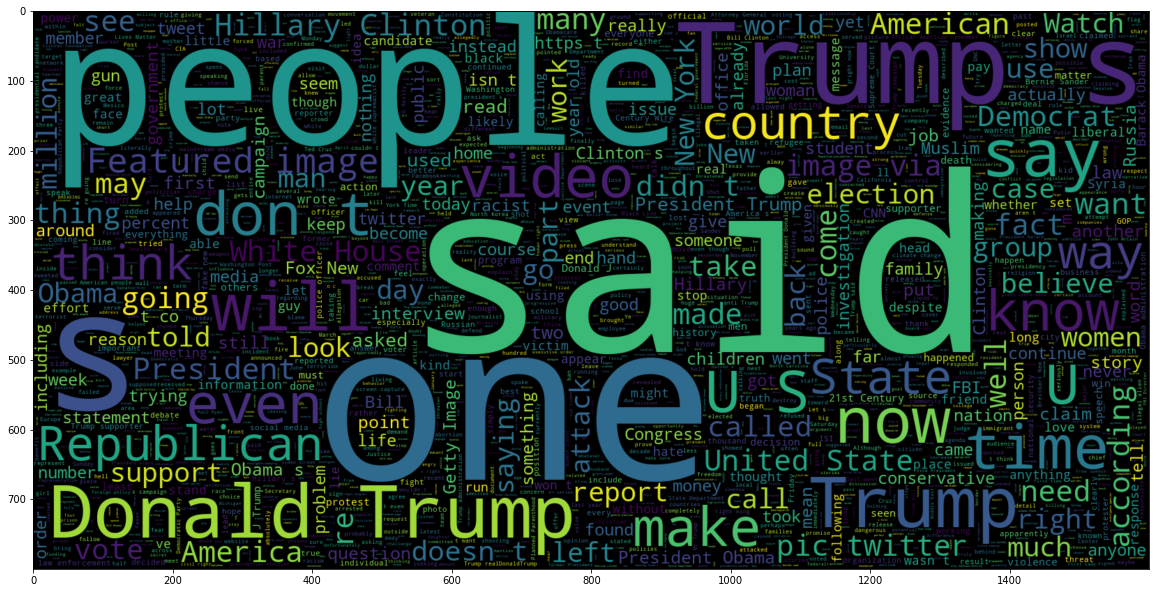

In [26]:
#word cloud for fake news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news_df[news_df.target == 1].content))
plt.imshow(wc, interpolation = 'bilinear')

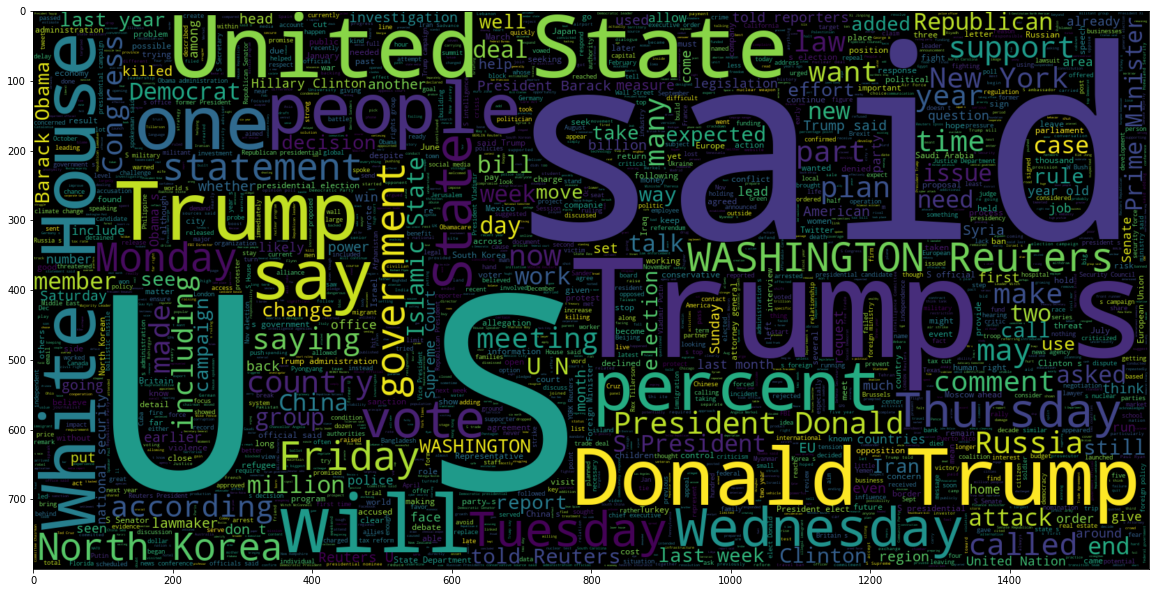

In [27]:
#word cloud for real news
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news_df[news_df.target == 0].content))
plt.imshow(wc, interpolation = 'bilinear')

In [28]:
X.shape

(44898,)

In [29]:
y.shape

(44898,)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=18)

In [31]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab,oov_token = '<UNK>')
tokenizer.fit_on_texts(x.decode('UTF-8') for x in X_train)

In [32]:
sequence_length = max([len(x.decode('UTF-8').split(' ')) for x in X_train]) #very large

In [59]:
lengths = [len(x.decode('UTF-8').split(' ')) for x in X_train]
p = np.array(lengths)
p_under500 = np.sum(p<500)/len(p)*100
p_under500              #  sequence_length 500 sufficient  

70.51617573361546

In [33]:
word_index = tokenizer.word_index

In [60]:
sequences = tokenizer.texts_to_sequences(x.decode('UTF-8') for x in X_train)

In [61]:
padded_sequences = pad_sequences(sequences,padding = 'post',truncating = 'post', maxlen = 512)

In [62]:
test_sequences = tokenizer.texts_to_sequences(x.decode('UTF-8') for x in X_test)
padded_test_sequences = pad_sequences(test_sequences,padding = 'post',truncating = 'post', maxlen = 512)

# Model

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

In [64]:
mycallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr = 1e-4),metrics=['accuracy'])
history = model.fit(padded_sequences, y_train, epochs=10,validation_data = (padded_test_sequences,y_test), batch_size=32, shuffle=True, callbacks=[mycallback])

Epoch 1/10
1123/1123 [==============================] - 888s 776ms/step - loss: 0.3770 - accuracy: 0.8006 - val_loss: 0.0121 - val_accuracy: 0.9971
Epoch 2/10
1123/1123 [==============================] - 856s 762ms/step - loss: 0.0120 - accuracy: 0.9980 - val_loss: 0.0121 - val_accuracy: 0.9965
Epoch 3/10
1123/1123 [==============================] - 842s 750ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0093 - val_accuracy: 0.9973
Epoch 4/10
1123/1123 [==============================] - 669s 596ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 5/10
1123/1123 [==============================] - 547s 487ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0058 - val_accuracy: 0.9988
Epoch 6/10
1123/1123 [==============================] - 530s 472ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0055 - val_accuracy: 0.9988
Epoch 7/10
1123/1123 [==============================] - 550s 490ms/step - loss: 6.8231e-04 - accuracy: 0.9999 - 

In [68]:
#model.save_weights()
model.save('fake_news_detection.h5')

In [67]:
model.save_weights('D:\DS_Projects\Fake_News_Detector')

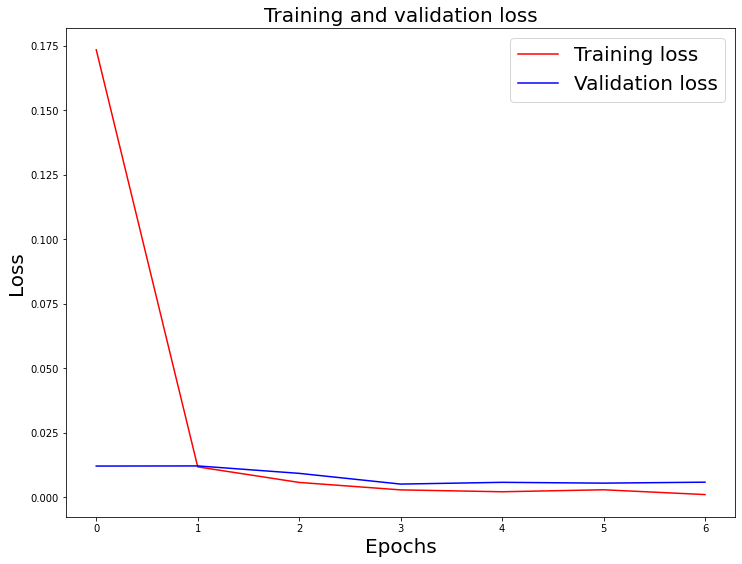

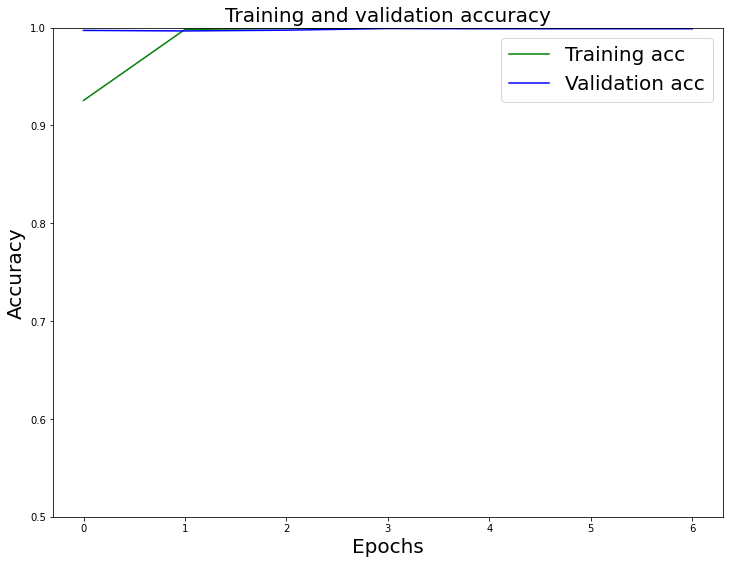

In [69]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [72]:
pred = model.predict(padded_test_sequences)
y_pred = []

for i in pred:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [73]:
print('Accuracy on testing set:', accuracy_score(y_pred, y_test))
print('Precision on testing set:', precision_score(y_pred, y_test))
print('Recall on testing set:', recall_score(y_pred, y_test))

Accuracy on testing set: 0.9987750556792873
Precision on testing set: 0.9993564993564994
Recall on testing set: 0.9982858367259482


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

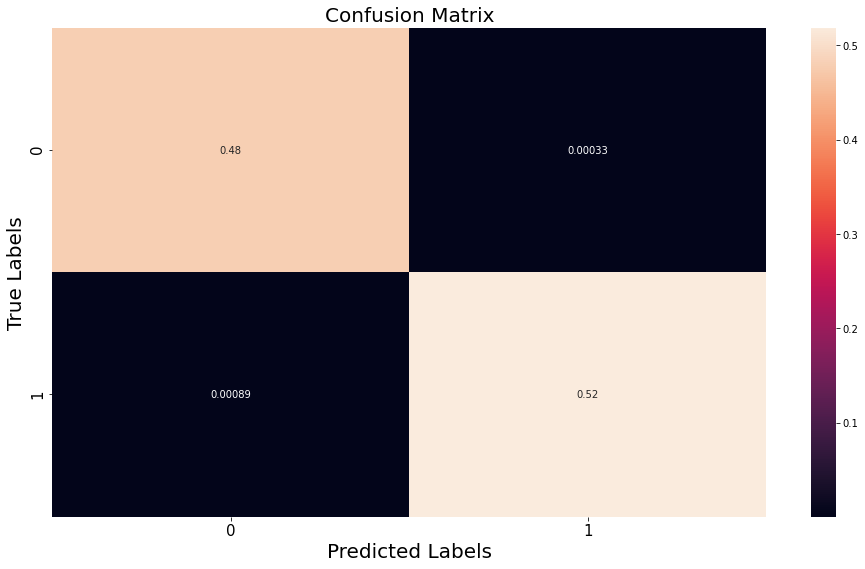

In [75]:
matrix = confusion_matrix(y_pred, y_test, normalize='all')
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [78]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
text = "The Pacific Northwest Tree Octopus" + "Your help is needed to save the Pacific Northwest Tree Octopus from extinction! Visit the official site to learn more about this elusive species, what you can do help, and share sitghings of this temperate rainforest cephalopods. It is pretty obvious that this clever and entertaining website is fake. It is not intended to be misleading, but a satirical site for a fictional animal that gained a surprise following. "

ex = tokenizer.texts_to_sequences([text.lower()])
padded_ex = pad_sequences(ex,padding = 'post',truncating = 'post', maxlen = 512)
p_ex=model.predict(padded_ex)

In [87]:
print(p_ex)

[[0.9999686]]


In [88]:
p_ex[0][0]>0.5

True

In [1]:
from flask import Flask, render_template, request